# Критерий хи-квадрат Пирсона $(\chi^2)$

In [1]:
from matplotlib import pyplot
import numpy
import math
from tqdm import tqdm
from collections import namedtuple

from scipy.stats import binom, chi2, chisquare, chi2_contingency, \
                        randint, kstest, norm, poisson
from statsmodels.stats.proportion import proportion_confint

numpy.random.seed(42)

In [2]:
def inverse_plot_colorscheme():
    import cycler
    def invert(color_to_convert):
        table = str.maketrans('0123456789abcdef', 'fedcba9876543210')
        return '#' + color_to_convert[1:].lower().translate(table).upper()
    update_dict = {}
    for key, value in pyplot.rcParams.items():
        if value == 'black':
            update_dict[key] = 'white'
        elif value == 'white':
            update_dict[key] = 'black'

    old_cycle = pyplot.rcParams['axes.prop_cycle']
    new_cycle = []
    for value in old_cycle:
        new_cycle.append({
            'color': invert(value['color'])
        })
    pyplot.rcParams.update(update_dict)
    pyplot.rcParams['axes.prop_cycle'] = cycler.Cycler(new_cycle)
    lec = pyplot.rcParams['legend.edgecolor']
    lec = str(1 - float(lec))
    pyplot.rcParams['legend.edgecolor'] = lec

In [3]:
inverse_plot_colorscheme()

## Критерий согласия $\chi^2$: простая гипотеза

Для проверки простой гипотезы согласия (принадлежности выборки к конкретному распределению с известными параметрами) мы пользовались критерием Колмогорова. Но мы также замечали, что этот критерий применим только для непрерывных распределений! Что же делать, когда у нас дискретное распределение? Например, мы хотим проверить кубик на честность.

> **Дисклеймер:** ниже игра в кости упоминается только в качестве мысленного эксперимента, в реальности в азартные игры мы не играем и вам не советуем 🙃

Обозначим за $\mathcal{P}$ распределение вероятностей выпадения граней кубика. Это дискретное распределение, обозначим за $p_i$ вероятность выпадения на кубике грани $i$. У настоящего, честного кубика грани выпадают с одинаковой вероятностью. Тогда наша гипотеза будет выглядеть следующим образом:

$$
H_0: p_1 = p_2 = p_3 = p_4 = p_5 = p_6 = \frac{1}{6}
$$

$$
H_1: H_0\text{ неверна}
$$

Пусть мы кинули кубик n раз, и у нас появилась реализация выборки  $X: x_1, x_2 \dots x_n$. Давайте обратим внимание, что нас не интересует порядок выпадения различных граней в реализации выборки. Мы можем записать результаты в виде таблицы частотности (frequency table) с числом выпадений каждой грани: исход $a_i$ случился $n_i$ раз. При этом $\sum n_i = n$.

Предположим, что мы ведем игру в кости, и видим у нашего противника следующую реализацию выборки из 60 бросков кубика:

|$a_i$|1|2|3|4|5|6|
|---|---|---|---|---|---|---|
|$n_i$|5|8|9|8|10|20|

Наблюдаем по таблице частотности как-то подозрительно много высоких значений 🤔

Как нам понять, не мухлюет ли наш противник, и стоит ли продолжать игру с ним?

![306611015 10162889108392524 2926140925072584145 n.jpg](attachment:4fb0c736-8974-408c-a435-34adb19f0559.jpg)

### Придумываем статистику критерия

Давайте поступим как и всегда: постараемся придумать некоторую статистику, показывающую, насколько экстремально от ожидаемого поведения находится наблюдаемая реализация выборки, а затем подумаем, как эта статистика распределена при нулевой гипотезе.

Нам нужно посчитать отклонение эмпирической вероятности наблюдаемого исхода от теоретической вероятности, заданной нулевой гипотезой. Кажется логичным взять за основу статистики $\left( \frac{n_i}{n}-p_i \right)$. Чтобы отклонения в разные стороны не обнуляли друг друга, давайте возведем ее в квадрат: $\left( \frac{n_i}{n}-p_i \right)^2$. Заметим, что модуль разницы между парой чисел 0.025 и 0.05 такой же, как и между 0.475 и 0.5. При этом кажется, что в первом случае "промахнулись" мы сильнее. Поэтому, давайте отнормируем нашу статистику обратно пропорционально $p_i$: $\frac{\left( \frac{n_i}{n}-p_i \right) ^2}{p_i}$. И, наконец, возьмем сумму по всем элементарным исходам:
$$\sum_i\frac{\left( \frac{n_i}{n}-p_i \right) ^2}{p_i}.$$

Видим, что минимальным значением статистики будет 0 (когда эмпирическая вероятность каждого исхода равна теоретической: $\frac{n_i}{n}=p_i$). То есть малые значения статистики будут свидетельствовать в пользу нулевой гипотезы, а большие — наоборот, в пользу альтернативной. Поэтому, критерий является односторонним: критическая область будет только справа, когда значение статистики больше некоторого порога. Давайте определим, что это за порог? Иными словами, как распределена данная статистика?

Рассмотрим самый простой случай: когда у нас всего два элементарных исхода $a_1$ и $a_2$ с вероятностями  $p_1 = p$ и $p_2 = 1 - p$ соответственно:
$$\sum_{i=1}^{2}\frac{\left(\frac{n_i}{n}-p_i\right)^2}{p_i} = $$

$$= \frac{\left(\frac{n_1}{n}-p\right)^2}{p} + \frac{\left(\frac{n - n_1}{n} - (1 - p)\right)^2}{1 - p} = $$

$$= \frac{\left(\frac{n_1}{n}-p\right)^2 (1-p)+ \left(\frac{n_1}{n} - p\right)^2 p}{p (1 - p)} = $$

$$= \frac{(n_1-n p)^2}{p (1 - p) n^2} \stackrel{[1]}{\sim} $$

$$ \sim \frac{\left(Binom(n, p)-n p\right)^2}{p (1 - p) n^2}  \stackrel{[2]}{\sim}$$

$$ \sim \frac{\left(\mathcal{N}\left(np, np(1-p)\right) - n p\right)^2}{p (1 - p) n^2} \stackrel{[3]}{=} $$

$$ = \frac{\mathcal{N}(0, 1)^2}{n}$$

[1]: Мы видим, что единственная случайная величина в выражении это $n_1$. При верной нулевой гипотезе она распределена по биномиальному закону как $Binom(n, p)$.

[2]: Вспомним ЦПТ: для больших $n$ случайная величина, распределенная как $Binom(n, p)$ эквивалентна нормальному распределению $\mathcal{N}\left(np, \sqrt{np(1-p)}\right)$ (параллельно заметим, что "большое" $n$ накладывает ограничение на условия применимости критерия, которые мы отдельно выпишем далее).

[3]: Пользуясь свойством нормального распределения $N(a, b) = a + \sqrt b \mathcal{N}(0,1)$, поймем что наша статистика распределена как $\frac{\mathcal{N}(0, 1)^2}{n}$.

Давайте избавимся от $n$, изначально запихнув его в нашу статистику:

$$\tau = n\sum_{i=1}^{2}\frac{(\frac{n_i}{n}-p)^2}{p} \sim \mathcal{N}(0, 1)^2$$

Ура! Мы узнали распределение статистики для случая двух исходов.

Вспомним, что квадрат стандартного нормального распределения по определению эквивалентен распределению хи-квадрат с одной степенью свободы: $\chi^2_{1}$.

Оказывается, что и для общего случая с числом исходов $k$ распределение статистики подчиняется закону:
$$\tau = n\sum_{i=1}^k\frac{(\frac{n_i}{n}-p_i)^2}{p_i}  \sim \chi^2_{k-1}$$

Доказывать мы это сейчас не будем. Если кого-то интересует доказательство, его можно найти по [ссылке](https://arxiv.org/pdf/1808.09171.pdf) (и не одно, а целых 7).

### Распределение $\chi^2$

Напомним, как вообще определяется распределение хи-квадрат:

> Пусть $z_{1},\ldots ,z_{k}$ — совместно независимые стандартные нормальные случайные величины, то есть $z_{i}\sim \mathcal{N}(0,1)$. Тогда случайная величина $x=z_{1}^{2}+\ldots +z_{k}^{2} \sim \chi ^{2}_k$ (имеет распределение хи-квадрат с $k$ степенями свободы).

А сейчас давайте посмотрим, как выглядит распределение $\chi^2_{k}$ для разного числа степеней свободы $k$:

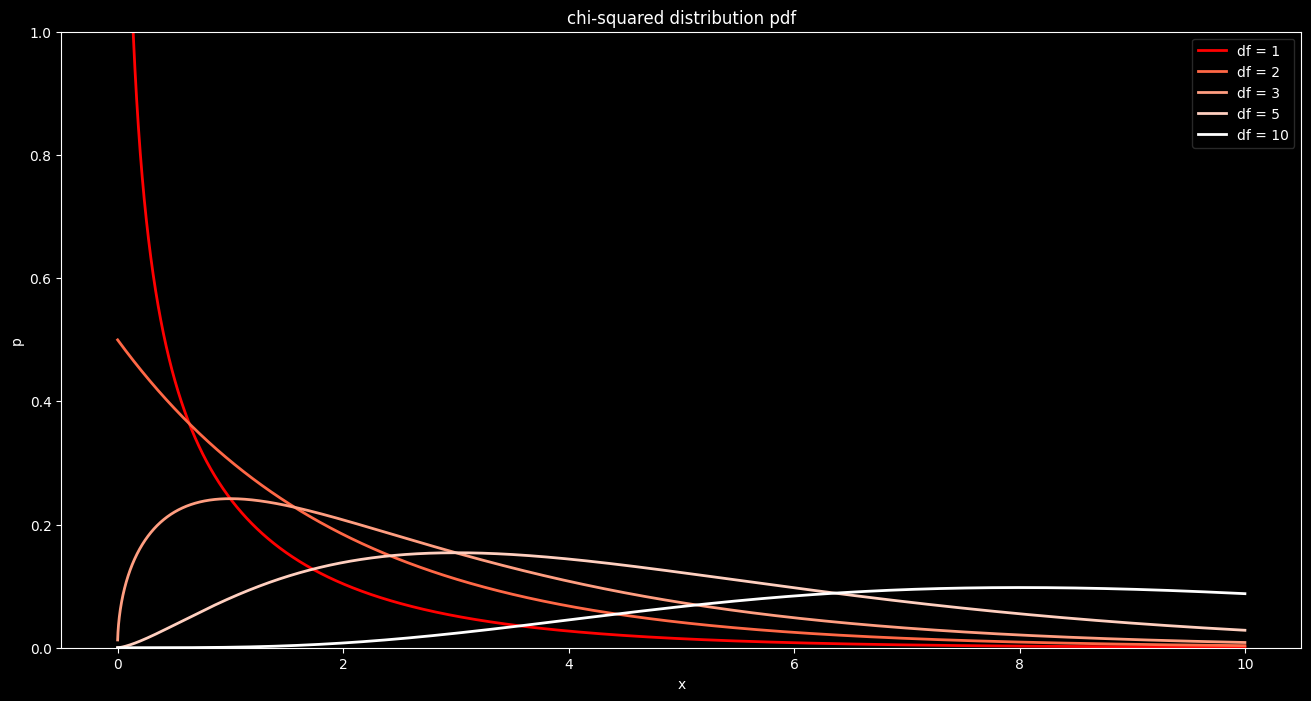

In [ ]:
x_axis = numpy.arange(start=0.001, stop=10, step=0.001)

pyplot.figure(figsize=(16, 8))

pyplot.plot(x_axis, chi2.pdf(x=x_axis, df=1), '#ff0000',
            linewidth=2.0, label='df = 1')
pyplot.plot(x_axis, chi2.pdf(x=x_axis, df=2), '#ff6846',
            linewidth=2.0, label='df = 2')
pyplot.plot(x_axis, chi2.pdf(x=x_axis, df=3), '#ff9e81',
            linewidth=2.0, label='df = 3')
pyplot.plot(x_axis, chi2.pdf(x=x_axis, df=5), '#ffcfbf',
            linewidth=2.0, label='df = 5')
pyplot.plot(x_axis, chi2.pdf(x=x_axis, df=10), '#ffffff',
            linewidth=2.0, label='df = 10')

pyplot.gca().set_ylim(bottom=0, top=1)

pyplot.legend(loc='best', frameon=True)
pyplot.title("chi-squared distribution pdf")
pyplot.xlabel("x")
pyplot.ylabel("p")

pyplot.show()

Видим, как 'пик' распределения при увеличении $k$ съезжает вправо и становится все более плоским.

### Алгоритм для проверки простой гипотезы согласия

Простая гипотеза - мы не пытаемся оценить параметры распределения по выборке. Т.е. мы сравниваем выборку не с семейством распределений, а с конкретным распределением (с определенными параметрами)

Прежде чем применять критерий давайте запишем его в качестве алгоритма:

1. Фиксируем уровень значимости $\alpha$.
2. Фиксируем дискретное распределение $\mathcal{P}$, на принадлежность к которому мы хотим проверить нашу выборку.
3. Записываем выборку с $k$ исходами в виде frequency table.
4. Если в ячейке таблицы стоит число <5 (либо <10 для случая frequency table 2x1), то объединяем исходы до тех пор, пока это условие не будет выполнено.
5. Рассчитываем статистику $$\tau = n\sum_{i=1}^k\frac{\left(\frac{n_i}{n}-p_i\right)^2}{p_i},$$
где $n$ - размер выборки, $k$ - число различных исходов, $n_i$ - число выпадений исхода $i$, $p_i$ - вероятность исхода $i$ согласно распределению $\mathcal{P}$.
6. Считаем $\it{\text{p-value}}$ как $P(X \geq \tau)$, где $X \sim \chi^2_{k-1}$.
7. Если $\it{\text{p-value}} \leq \alpha$, то гипотезу отвергаем.

Условия применимости:
- распределение дискретное;
- число наблюдений в каждой ячейке выше 5;
- для случая frequency table 2x1 число наблюдений в каждой ячейке выше 10.

### Применение критерия согласия $\chi^2$ для проверки простой гипотезы

Вооружившись новым критерием давайте вернемся к нашей партии в кости с противником, которого мы подозреваем в шулерстве. Напомним, что он выкинул следующую реализацию выборки из 60 бросков кубика:

|$a_i$|1|2|3|4|5|6|
|---|---|---|---|---|---|---|
|$n_i$|5|8|9|8|10|20|

Мы хотим проверить гипотезу:  
$$H_0: p_1 = p_2 = p_3 = p_4 = p_5 = p_6 = \frac{1}{6}$$

Давайте посчитаем значение статистики $\tau$:

In [ ]:
frequencies = [5, 8, 9, 8, 10, 20] # наблюдаемые

tau = sum(frequencies) * \
    sum([(f / sum(frequencies) - 1/6) ** 2 / (1/6) for f in frequencies])

tau

13.4

И сосчитаем $\it{\text{p-value}}$ (распределение $\chi^2$ есть в библиотеке [scipy.stats.chi2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2.html)):

In [ ]:
1 - chi2.cdf(x=tau, df=6 - 1)

0.019905220334774376

Либо можем просто воспользоваться функцией для проверки критерия по таблице частотности [scipy.stats.chisquare](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html).

Функция принимает на вход следующие параметры:
- f_obsarray_like: наблюдаемые частоты.
- f_exparray_like: ожидаемые частоты.
- ddof: в качестве распределения берется хи-квадрат с числом степеней свободы $k-1-\it{\text{ddof}}$ (по умолчанию $\it{\text{ddof}} = 0$, другие значения нам понадобятся позже в этой лекции)

In [ ]:
chisquare(f_obs=[5, 8, 9, 8, 10, 20], f_exp=[10, 10, 10, 10, 10, 10])

Power_divergenceResult(statistic=13.4, pvalue=0.01990522033477438)

Видим, что на уровне значимости 5% гипотеза отвергается, то есть с таким противником лучше не играть.

**Обратите внимание, что критерий не показывает, как именно смещено распределение кубика!** Критерий проверяет исключительно гипотезу о равенстве распределений.

### Дискретизация непрерывного распределения

На самом деле мы можем превратить любое непрерывное распределение в дискретное. Для этого нам нужно задать бины: если реализация $x$ непрерывной случайной величины находится между границами интервала $X^{\it{\text{left}}}_i \leq x < X^{\it{\text{right}}}_i$, считаем это элементарным исходом $X_i$.


Давайте попробуем задать бины следующим образом: разобьем непрерывное распределение на несколько равновероятных интервалов и с помощью критерия Хи-квадрат будем проверять гипотезу о принадлежности выборки равномерному распределению с числом исходов равным числу бинов.

Будем проверять гипотезу о принадлежности выборки стандартному нормальному распределению с помощью критерия Колмогорова и критерия Хи-квадрат для дискретизации этого распределения (с различным числом бинов).

In [4]:
MonteCarloResults= namedtuple('MonteCarloResults', ['positive_rate', \
                                                    'confint_left_bound',\
                                                    'confint_right_bound'])

def gen_monte_carlo_exp_for_norm_kstest(n, loc, scale, alpha, N_runs):
    """
        Функция для проверки критерия согласия Колмогорова для
            нормального распределения с помощью метода Монте-Карло

        Возвращает долю отвержений гипотезы и доверительный интервал
            для этой доли

        Параметры:
            - n: размер выборки
            - loc: истинное среднее распределения
            - scale: истинное среднеквадратичное отклонение распределения
            - alpha: уровень значимости
            - N_runs: число экспериментов в методе Монте-Карло
    """

    positive = 0

    for i in range(N_runs):

        sample = norm.rvs(loc = loc, scale = scale, size = n)

        # критерий Колмогорова
        pvalue = kstest(sample, cdf=norm.cdf).pvalue

        if pvalue<=alpha:
            positive+=1

    positive_rate = positive/N_runs
    confint = proportion_confint(count = positive, nobs = N_runs,
                                 alpha = 0.05, method='wilson')

    return MonteCarloResults(**{'positive_rate': positive_rate,
                                'confint_left_bound': confint[0],
                                'confint_right_bound': confint[1]})

In [5]:
MonteCarloResults= namedtuple('MonteCarloResults', ['positive_rate',
                                                    'confint_left_bound',
                                                    'confint_right_bound'])

def gen_monte_carlo_exp_for_discrete_norm_chi_sq(n, loc, scale, n_bins,
                                                 alpha, N_runs):
    """
        Функция для проверки критерия согласия Хи-квадрат для
            дискретизированного нормального распределения
            с помощью метода Монте-Карло

        Возвращает долю отвержений гипотезы и доверительный интервал
            для этой доли

        Параметры:
            - n: размер выборки
            - loc: истинное среднее распределения
            - scale: истинное среднеквадратичное отклонение распределения
            - n_bins: число бинов
            - alpha: уровень значимости
            - N_runs: число экспериментов в методе Монте-Карло
    """

    positive = 0

    # зададим список границ бинов для стандартного нормального распределения
    # разбиваем на такие корзины, что если H0 верна, то вероятности попадания в корзины +- равны (проверить, так ли это тут)
    # так как для хи-квадрата желательно, чтобы не было корзин, в которых меньше 5 объектов
    # эта функция создаст такие корзины, что в случае равенства H0 объекты между ними разобьются в среднем поровну
    bins = [norm.ppf(i/n_bins) for i in range(n_bins+1)]

    for _ in range(N_runs):

        sample = norm.rvs(loc = loc, scale = scale, size = n)

        # получаем таблицу частотности по корзинам, которые мы только что посчитали
        frequency_table = numpy.histogram(a = sample, bins = bins)[0]

        # считаем p-value  c пом. хи-квадрат
        pvalue = chisquare(f_obs=frequency_table,
                           f_exp=n_bins*[n/n_bins])[1]

        if pvalue<=alpha:
            positive+=1

    positive_rate = positive/N_runs
    confint = proportion_confint(count = positive, nobs = N_runs,
                                 alpha = 0.05, method='wilson')

    return MonteCarloResults(**{'positive_rate': positive_rate,
                                'confint_left_bound': confint[0],
                                'confint_right_bound': confint[1]})

Для проверим, что критерии вообще корректны (FPR <= alpha)  

In [6]:
FPR_list_ks = []
FPR_list_chi_sq_4_bins = [] # Хи-квадрат с 4 корзинами
FPR_list_chi_sq_8_bins = [] # Хи-квадрат с 8 корзинами

# перебираем размер выборки n
for i in tqdm(numpy.arange(100, 1000, 200, dtype = int)):
    mmk_res_ks = gen_monte_carlo_exp_for_norm_kstest(n = i, loc = 0,
                                                     scale = 1,
                                                     alpha = 0.05,
                                                     N_runs = 10000)
    FPR_list_ks.append([i, mmk_res_ks])

    mmk_res_chi_sq_4_bins = gen_monte_carlo_exp_for_discrete_norm_chi_sq(n = i,
                                                                         loc = 0,
                                                                         scale = 1,
                                                                         n_bins = 4,
                                                                         alpha = 0.05,
                                                                         N_runs = 10000)
    FPR_list_chi_sq_4_bins.append([i, mmk_res_chi_sq_4_bins])

    mmk_res_chi_sq_8_bins = gen_monte_carlo_exp_for_discrete_norm_chi_sq(n = i,
                                                                         loc = 0,
                                                                         scale = 1,
                                                                         n_bins = 8,
                                                                         alpha = 0.05,
                                                                         N_runs = 10000)
    FPR_list_chi_sq_8_bins.append([i, mmk_res_chi_sq_8_bins])

100%|██████████| 5/5 [01:40<00:00, 20.05s/it]


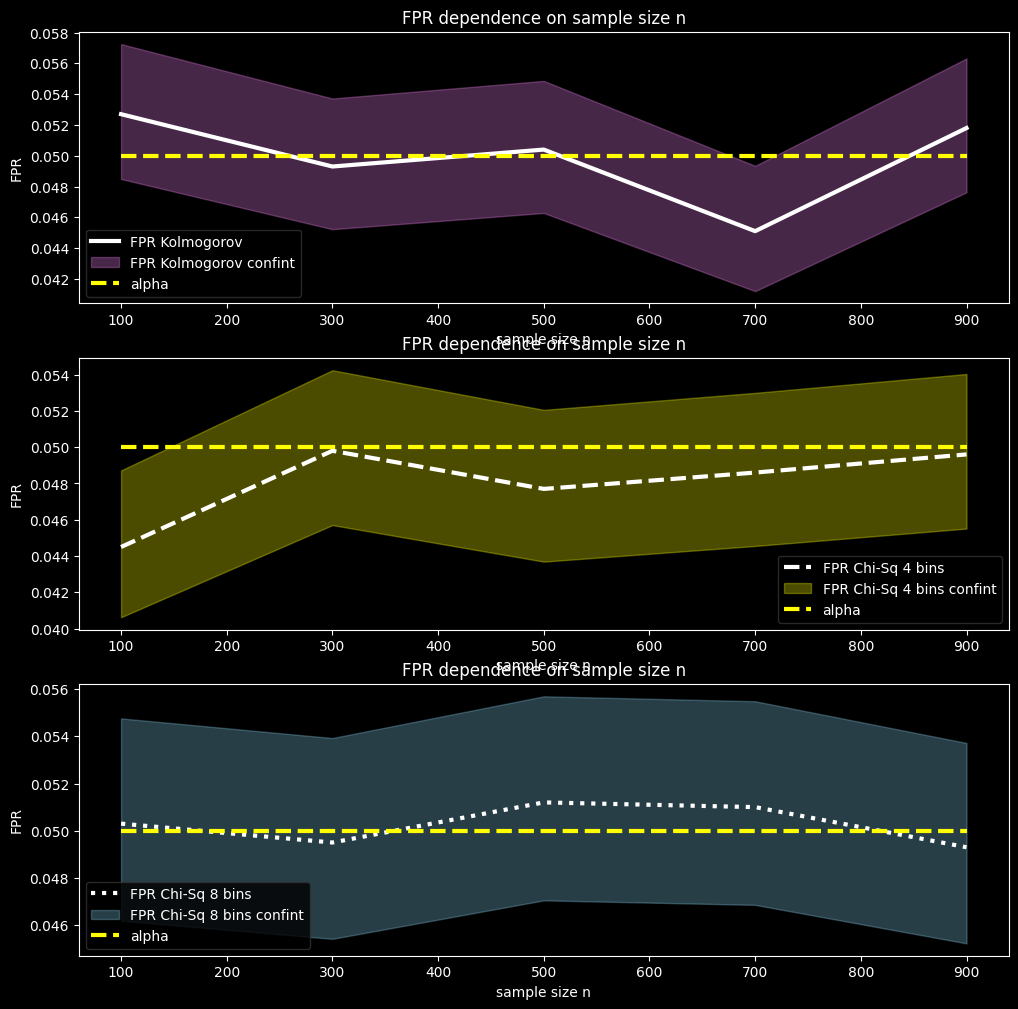

In [10]:
pyplot.figure(figsize=(12, 12))

pyplot.subplot(3, 1, 1)
pyplot.plot([elem[0] for elem in FPR_list_ks],
            [elem[1].positive_rate for elem in FPR_list_ks],
            color = 'white', linewidth=3.0, label='FPR Kolmogorov')
pyplot.fill_between([elem[0] for elem in FPR_list_ks],
                    [elem[1].confint_left_bound for elem in FPR_list_ks],
                    [elem[1].confint_right_bound for elem in FPR_list_ks],
                    color = 'violet', alpha = 0.3,
                    label='FPR Kolmogorov confint')
pyplot.plot([elem[0] for elem in FPR_list_ks], numpy.array([0.05]*len(FPR_list_ks)),
            color = 'yellow', linestyle = 'dashed', linewidth=3.0, label='alpha')
pyplot.legend(loc='best')
pyplot.title("FPR dependence on sample size n")
pyplot.xlabel("sample size n")
pyplot.ylabel("FPR")

pyplot.subplot(3, 1, 2)
pyplot.plot([elem[0] for elem in FPR_list_chi_sq_4_bins],
            [elem[1].positive_rate for elem in FPR_list_chi_sq_4_bins],
            color = 'white', linewidth=3.0,
            linestyle = 'dashed', label='FPR Chi-Sq 4 bins')
pyplot.fill_between([elem[0] for elem in FPR_list_chi_sq_4_bins],
                    [elem[1].confint_left_bound for elem in FPR_list_chi_sq_4_bins],
                    [elem[1].confint_right_bound for elem in FPR_list_chi_sq_4_bins],
                    color = 'yellow', alpha = 0.3, label='FPR Chi-Sq 4 bins confint')
pyplot.plot([elem[0] for elem in FPR_list_ks],
            numpy.array([0.05]*len(FPR_list_ks)), color = 'yellow',
            linestyle = 'dashed', linewidth=3.0, label='alpha')
pyplot.legend(loc='best')
pyplot.title("FPR dependence on sample size n")
pyplot.xlabel("sample size n")
pyplot.ylabel("FPR")


pyplot.subplot(3, 1, 3)
pyplot.plot([elem[0] for elem in FPR_list_chi_sq_8_bins],
            [elem[1].positive_rate for elem in FPR_list_chi_sq_8_bins],
            color = 'white', linewidth=3.0, linestyle = 'dotted', label='FPR Chi-Sq 8 bins')
pyplot.fill_between([elem[0] for elem in FPR_list_chi_sq_8_bins],
                    [elem[1].confint_left_bound for elem in FPR_list_chi_sq_8_bins],
                    [elem[1].confint_right_bound for elem in FPR_list_chi_sq_8_bins],
                    color = 'skyblue', alpha = 0.3, label='FPR Chi-Sq 8 bins confint')

pyplot.plot([elem[0] for elem in FPR_list_ks], numpy.array([0.05]*len(FPR_list_ks)),
            color = 'yellow', linestyle = 'dashed', linewidth=3.0, label='alpha')
pyplot.legend(loc='best')
pyplot.title("FPR dependence on sample size n")
pyplot.xlabel("sample size n")
pyplot.ylabel("FPR")

pyplot.show()

**Вывод:** мы не видим стат. значимого отличия FPR от заявленной $\alpha$ ни в одном из случаев. То есть критерии как минимум корректны

Теперь давайте сдвинем распределение и посмотрим на мощность:

Проверим, что будет при сдвиге распределения (та же дисперсия, разные мат. ожидания)

In [8]:
TPR_list_ks = []
TPR_list_chi_sq_4_bins = []
TPR_list_chi_sq_8_bins = []

# перебираем размер выборки n
for i in tqdm(numpy.arange(100, 1000, 200, dtype = int)):
    mmk_res_ks = gen_monte_carlo_exp_for_norm_kstest(n = i, loc = 0.2, scale = 1,
                                                     alpha = 0.05, N_runs = 10000)
    TPR_list_ks.append([i, mmk_res_ks])

    mmk_res_chi_sq_4_bins = gen_monte_carlo_exp_for_discrete_norm_chi_sq(n = i,
                                                                         loc = 0.2,
                                                                         scale = 1,
                                                                         n_bins = 4,
                                                                         alpha = 0.05,
                                                                         N_runs = 10000)
    TPR_list_chi_sq_4_bins.append([i, mmk_res_chi_sq_4_bins])

    mmk_res_chi_sq_8_bins = gen_monte_carlo_exp_for_discrete_norm_chi_sq(n = i,
                                                                         loc = 0.2,
                                                                         scale = 1,
                                                                         n_bins = 8,
                                                                         alpha = 0.05,
                                                                         N_runs = 10000)
    TPR_list_chi_sq_8_bins.append([i, mmk_res_chi_sq_8_bins])

100%|██████████| 5/5 [01:59<00:00, 23.95s/it]


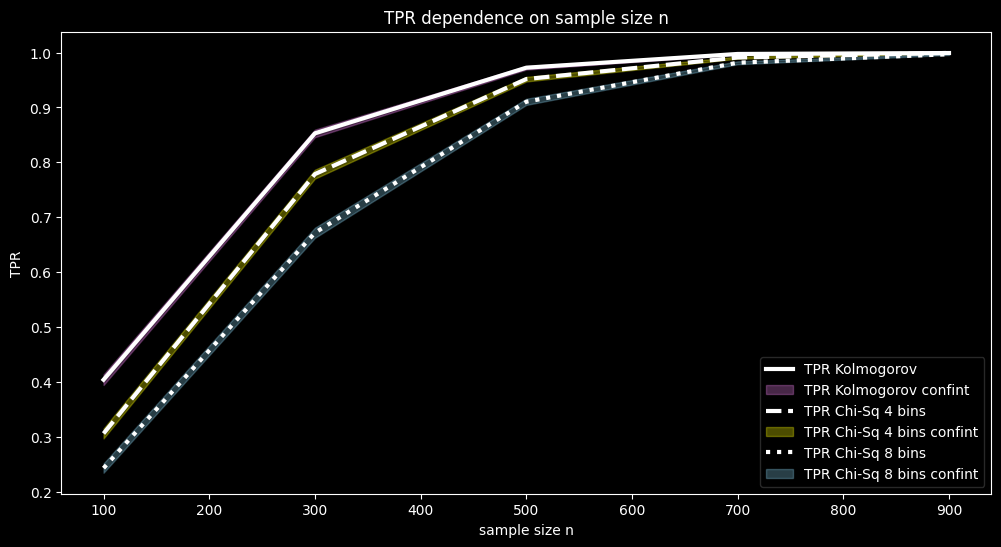

In [11]:
pyplot.figure(figsize=(12, 6))

pyplot.plot([elem[0] for elem in TPR_list_ks],
            [elem[1].positive_rate for elem in TPR_list_ks],
            color = 'white', linewidth=3.0, label='TPR Kolmogorov')
pyplot.fill_between([elem[0] for elem in TPR_list_ks],
                    [elem[1].confint_left_bound for elem in TPR_list_ks],
                    [elem[1].confint_right_bound for elem in TPR_list_ks],
                    color = 'violet', alpha = 0.3, label='TPR Kolmogorov confint')

pyplot.plot([elem[0] for elem in TPR_list_chi_sq_4_bins],
            [elem[1].positive_rate for elem in TPR_list_chi_sq_4_bins],
            color = 'white', linestyle = 'dashed', linewidth=3.0,
            label='TPR Chi-Sq 4 bins')
pyplot.fill_between([elem[0] for elem in TPR_list_chi_sq_4_bins],
                    [elem[1].confint_left_bound for elem in TPR_list_chi_sq_4_bins],
                    [elem[1].confint_right_bound for elem in TPR_list_chi_sq_4_bins],
                    color = 'yellow', alpha = 0.3, label='TPR Chi-Sq 4 bins confint')

pyplot.plot([elem[0] for elem in TPR_list_chi_sq_8_bins],
            [elem[1].positive_rate for elem in TPR_list_chi_sq_8_bins],
            color = 'white', linestyle = 'dotted', linewidth=3.0, label='TPR Chi-Sq 8 bins')
pyplot.fill_between([elem[0] for elem in TPR_list_chi_sq_8_bins],
                    [elem[1].confint_left_bound for elem in TPR_list_chi_sq_8_bins],
                    [elem[1].confint_right_bound for elem in TPR_list_chi_sq_8_bins],
                    color = 'skyblue', alpha = 0.3, label='TPR Chi-Sq 8 bins confint')

pyplot.legend(loc='best')
pyplot.title("TPR dependence on sample size n")
pyplot.xlabel("sample size n")
pyplot.ylabel("TPR")

pyplot.show()

**Вывод:** для сдвига распределения мощность критерия Колмогорова > Хи-квадрат с 4 ячейками > Хи-квадрат с 8 ячейками.

Давайте проверим, что будет происходить при изменении дисперсии?

In [ ]:
TPR_list_ks = []
TPR_list_chi_sq_4_bins = []
TPR_list_chi_sq_8_bins = []

# перебираем размер выборки n
for i in tqdm(numpy.arange(100, 1000, 200, dtype = int)):
    mmk_res_ks = gen_monte_carlo_exp_for_norm_kstest(n = i, loc = 0,
                                                     scale = 1.1,
                                                     alpha = 0.05,
                                                     N_runs = 10000)
    TPR_list_ks.append([i, mmk_res_ks])

    mmk_res_chi_sq_4_bins = gen_monte_carlo_exp_for_discrete_norm_chi_sq(n = i,
                                                                         loc = 0,
                                                                         scale = 1.1,
                                                                         n_bins = 4,
                                                                         alpha = 0.05,
                                                                         N_runs = 10000)
    TPR_list_chi_sq_4_bins.append([i, mmk_res_chi_sq_4_bins])

    mmk_res_chi_sq_8_bins = gen_monte_carlo_exp_for_discrete_norm_chi_sq(n = i,
                                                                         loc = 0,
                                                                         scale = 1.1,
                                                                         n_bins = 8,
                                                                         alpha = 0.05,
                                                                         N_runs = 10000)
    TPR_list_chi_sq_8_bins.append([i, mmk_res_chi_sq_8_bins])

100%|██████████| 5/5 [01:12<00:00, 14.41s/it]


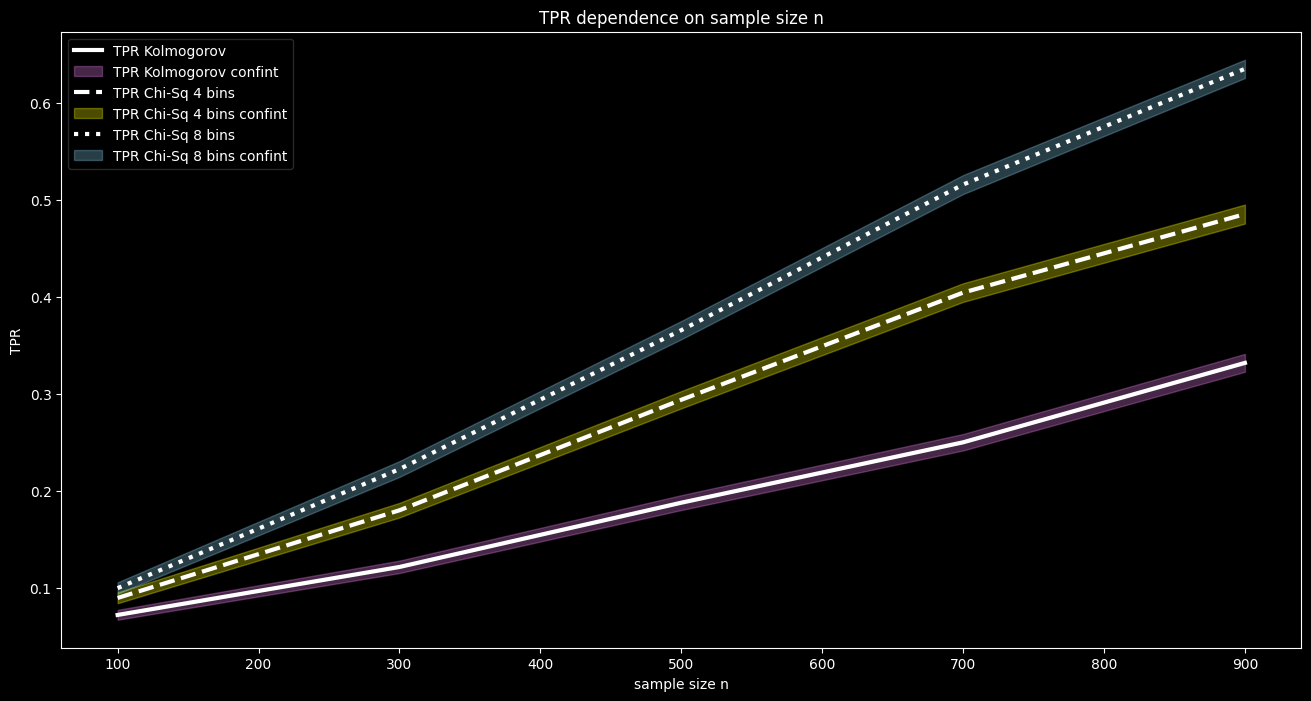

In [ ]:
pyplot.figure(figsize=(12, 6))

pyplot.plot([elem[0] for elem in TPR_list_ks],
            [elem[1].positive_rate for elem in TPR_list_ks],
            color = 'white', linewidth=3.0, label='TPR Kolmogorov')
pyplot.fill_between([elem[0] for elem in TPR_list_ks],
                    [elem[1].confint_left_bound for elem in TPR_list_ks],
                    [elem[1].confint_right_bound for elem in TPR_list_ks],
                    color = 'violet', alpha = 0.3, label='TPR Kolmogorov confint')

pyplot.plot([elem[0] for elem in TPR_list_chi_sq_4_bins],
            [elem[1].positive_rate for elem in TPR_list_chi_sq_4_bins],
            color = 'white', linestyle = 'dashed', linewidth=3.0, label='TPR Chi-Sq 4 bins')
pyplot.fill_between([elem[0] for elem in TPR_list_chi_sq_4_bins],
                    [elem[1].confint_left_bound for elem in TPR_list_chi_sq_4_bins],
                    [elem[1].confint_right_bound for elem in TPR_list_chi_sq_4_bins],
                    color = 'yellow', alpha = 0.3, label='TPR Chi-Sq 4 bins confint')

pyplot.plot([elem[0] for elem in TPR_list_chi_sq_8_bins],
            [elem[1].positive_rate for elem in TPR_list_chi_sq_8_bins],
            color = 'white', linestyle = 'dotted', linewidth=3.0, label='TPR Chi-Sq 8 bins')
pyplot.fill_between([elem[0] for elem in TPR_list_chi_sq_8_bins],
                    [elem[1].confint_left_bound for elem in TPR_list_chi_sq_8_bins],
                    [elem[1].confint_right_bound for elem in TPR_list_chi_sq_8_bins],
                    color = 'skyblue', alpha = 0.3, label='TPR Chi-Sq 8 bins confint')

pyplot.legend(loc='best')
pyplot.title("TPR dependence on sample size n")
pyplot.xlabel("sample size n")
pyplot.ylabel("TPR")

pyplot.show()

**Вывод:** для изменения дисперсии распределения мощность критерия Хи-квадрат с 8 ячейками > Хи-квадрат с 4 ячейками > Колмогорова.  
  
В целом интуитивно можно придумать, почему круче всех оказался Хи-квадрат с 8 ячейками. (есть в видосе)

Давайте дополнительно посмотрим на сдвиг + изменение дисперсии:

In [ ]:
TPR_list_ks = []
TPR_list_chi_sq_4_bins = []
TPR_list_chi_sq_8_bins = []

# перебираем размер выборки n
for i in tqdm(numpy.arange(100, 1000, 200, dtype = int)):
    mmk_res_ks = gen_monte_carlo_exp_for_norm_kstest(n = i,
                                                     loc = 0.2,
                                                     scale = 1.1,
                                                     alpha = 0.05,
                                                     N_runs = 10000)
    TPR_list_ks.append([i, mmk_res_ks])

    mmk_res_chi_sq_4_bins = gen_monte_carlo_exp_for_discrete_norm_chi_sq(n = i,
                                                                         loc = 0.2,
                                                                         scale = 1.1,
                                                                         n_bins = 4,
                                                                         alpha = 0.05,
                                                                         N_runs = 10000)
    TPR_list_chi_sq_4_bins.append([i, mmk_res_chi_sq_4_bins])

    mmk_res_chi_sq_8_bins = gen_monte_carlo_exp_for_discrete_norm_chi_sq(n = i,
                                                                         loc = 0.2,
                                                                         scale = 1.1,
                                                                         n_bins = 8,
                                                                         alpha = 0.05,
                                                                         N_runs = 10000)
    TPR_list_chi_sq_8_bins.append([i, mmk_res_chi_sq_8_bins])

100%|██████████| 5/5 [01:29<00:00, 17.87s/it]


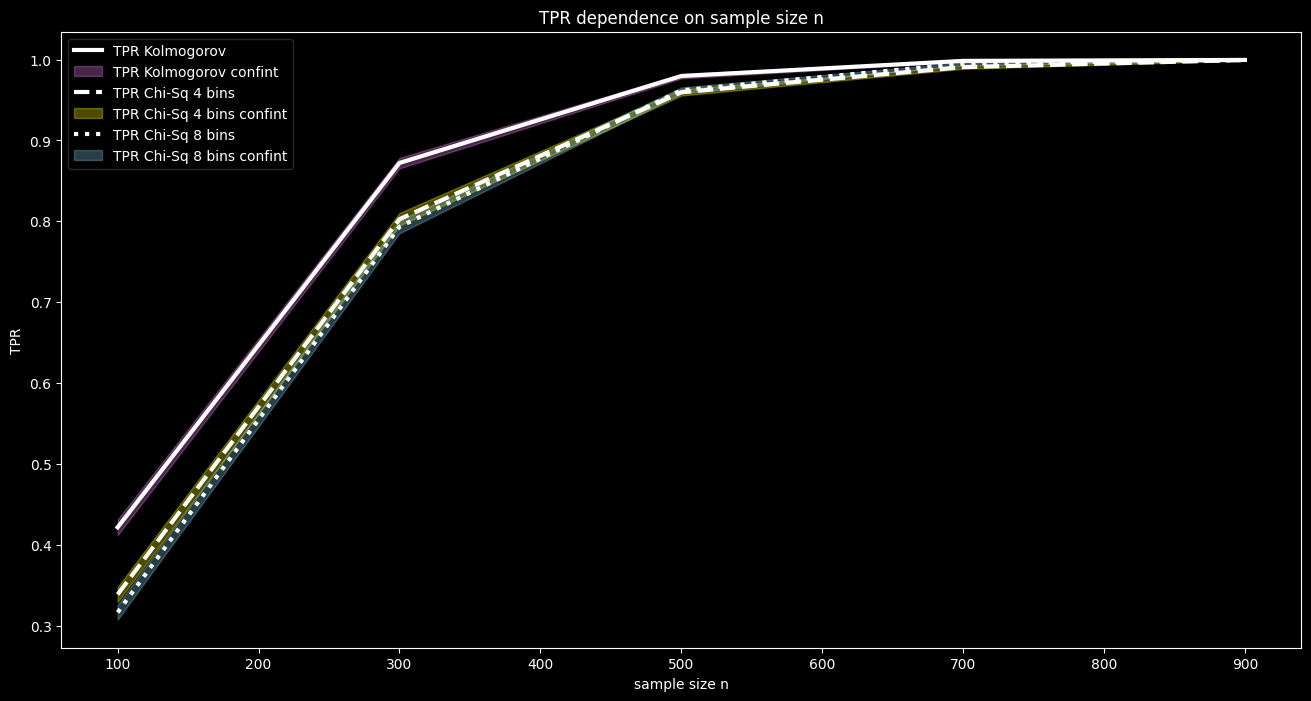

In [ ]:
pyplot.figure(figsize=(16, 8))

pyplot.plot([elem[0] for elem in TPR_list_ks],
            [elem[1].positive_rate for elem in TPR_list_ks],
            color = 'white', linewidth=3.0, label='TPR Kolmogorov')
pyplot.fill_between([elem[0] for elem in TPR_list_ks],
                    [elem[1].confint_left_bound for elem in TPR_list_ks],
                    [elem[1].confint_right_bound for elem in TPR_list_ks],
                    color = 'violet', alpha = 0.3, label='TPR Kolmogorov confint')

pyplot.plot([elem[0] for elem in TPR_list_chi_sq_4_bins],
            [elem[1].positive_rate for elem in TPR_list_chi_sq_4_bins],
            color = 'white', linestyle = 'dashed', linewidth=3.0, label='TPR Chi-Sq 4 bins')
pyplot.fill_between([elem[0] for elem in TPR_list_chi_sq_4_bins],
                    [elem[1].confint_left_bound for elem in TPR_list_chi_sq_4_bins],
                    [elem[1].confint_right_bound for elem in TPR_list_chi_sq_4_bins],
                    color = 'yellow', alpha = 0.3, label='TPR Chi-Sq 4 bins confint')

pyplot.plot([elem[0] for elem in TPR_list_chi_sq_8_bins],
            [elem[1].positive_rate for elem in TPR_list_chi_sq_8_bins],
            color = 'white', linestyle = 'dotted', linewidth=3.0, label='TPR Chi-Sq 8 bins')
pyplot.fill_between([elem[0] for elem in TPR_list_chi_sq_8_bins],
                    [elem[1].confint_left_bound for elem in TPR_list_chi_sq_8_bins],
                    [elem[1].confint_right_bound for elem in TPR_list_chi_sq_8_bins],
                    color = 'skyblue', alpha = 0.3, label='TPR Chi-Sq 8 bins confint')

pyplot.legend(loc='best')
pyplot.title("TPR dependence on sample size n")
pyplot.xlabel("sample size n")
pyplot.ylabel("TPR")

pyplot.show()

**Вывод:** в зависимости от характера эффекта разные критерии будет показывать наибольшую мощность. Поэтому, если для решения вашей задачи нужно применить критерий согласия, то можете смоделировать каким-нибудь распределением данные, которые вы ожидаете получить, и найти оптимальный критерий с помощью метода Монте-Карло. Но на самом деле, изменение дисперсии это гораздо более редко встречающийся на реальных данных характер изменения, чем сдвиг, поэтому
основным критерием для решения задачи согласия для непрерывных распределений все же будет критерий Колмогорова.

На досуге можете подумать, почему критерий согласия Колмогорова справляется с изменением дисперсии не очень хорошо.

## Критерий согласия $\chi^2$: сложная гипотеза

Что же делать, если нам встретится сложная гипотеза для дискретного распределения?

Напомним, что сложной гипотезой называют предположение о том, что распределение, из которого получена наша выборка, принадлежит некоторому семейству распределений, зависящему от набора параметров.

Нам надо воспользоваться той же идеей, которая была заложена в критерии Колмогорова с поправкой Лиллиефорса: оценить параметры распределения по выборке. Поскольку выполняя это действие мы неизбежно переобучаемся: оценки описывают выборку лучше, чем истинные параметры, то распределение статистики неизбежно поменяется.

Приведем факт без доказательства: при проверке сложной гипотезы с $k$ исходами при оценке $v$ различных параметров с помощью оценки максимального правдоподобия статистика $\tau$ при выполнении нулевой гипотезы будет распределена как $\chi^2_{k-v-1}$.

Как понять, сколько параметров нужно оценить у семейства распределений? Покажем на примере. Для проверки гипотезы согласия о принадлежности выборки:
- распределению $\mathcal{N}(0,1)$ параметры оценивать не нужно (простая гипотеза);
- семейству распределений $\{\mathcal{N}(\mu,1)\}_{\mu \in \mathbb{R}}$ нужно оценить 1 параметр (сложная гипотеза);
- семейству распределений $\{\mathcal{N}(\mu,\sigma^2)\}_{\mu, \sigma \in \mathbb{R}}$ нужно оценить 2 параметра (сложная гипотеза).

### Оценка максимального правдоподобия (ОМП)

Пусть дано параметрическое семейство распределений вероятности $\{\mathcal {P} _{\theta }\}_{\theta \in \Theta }$, и дана выборка $X_{1},\ldots ,X_{n}\sim \mathcal {P} _{\theta }$ для некоторого $\theta \in \Theta$.

Оценкой максимального правдоподобия будет значение вектора параметров $\theta$, на котором достигается максимум функции правдоподобия:

$${\displaystyle {\hat {\theta }}_{\mathrm {M\Pi } }={\hat {\theta }}_{\mathrm {M\Pi } }(X_{1},\ldots ,X_{n})=\mathop {\rm {argmax}} \limits _{\theta \in \Theta }L(X_{1},\ldots ,X_{n}\mid \theta )}$$

Функцией правдоподобия $L({\mathbf  {x}}\mid \theta )\colon \Theta \to {\mathbb  {R}}$ будет являться произведение плотностей вероятности (для непрерывного $\mathcal {P}$), либо произведение вероятностей элементарных исходов (для дискретного $\mathcal {P}$):

$$L({\mathbf  {x}}\mid \theta ) = \prod _{i=1}^{n}P(X = X_i|\theta)$$

Поскольку максимум функции правдоподобия такой же, как у ее логарифма, мы можем оптимизировать логарифм функции правдоподобия $l$:

$$l(X_{1},\ldots ,X_{n}\mid \theta) = ln(L(X_{1},\ldots ,X_{n}\mid \theta)) =\sum _{i=1}^{n}ln(P(X = X_i|\theta))$$

Это удобнее, поскольку произведение заменяется суммой (по свойствам логарифма).


Максимум функции правдоподобия можно найти, приравняв к нулю производную логарифма функции правдоподобия, либо перебором. Пример нахождения максимума функции правдоподобия перебором рассмотрим немного позже, когда будем решать задачу.

### Алгоритм для проверки сложной гипотезы согласия

Давайте запишем критерий в виде алгоритма:

1. Фиксируем уровень значимости $\alpha$.
2. Фиксируем семейство $v$-параметрических дискретных распределений $\mathcal{P}$, на принадлежность к которому мы хотим проверить нашу выборку.
3. Записываем выборку с $k$ исходами в виде frequency table.
4. Если в ячейке таблицы стоит число <5 (либо <10 для случая frequency table 2x1), то объединяем исходы до тех пор, пока это условие не будет выполнено.
5. По выборке оцениваем $v$ параметров с помощью ОМП.
6. Рассчитываем статистику $$\tau = n\sum_{i=1}^k\frac{\left(\frac{n_i}{n}-p_i\right)^2}{p_i},$$
где $n$ - размер выборки, $k$ - число различных исходов, $n_i$ - число выпадений исхода $i$, $p_i$ - вероятность исхода $i$ согласно распределению $\mathcal{P}$ с оцененными параметрами.
7. Считаем $\it{\text{p-value}}$ как $P(X \geq \tau)$, где $X \sim \chi^2_{k-v-1}$.
8. Если $\it{\text{p-value}} \leq \alpha$, то гипотезу отвергаем.

Условия применимости такие же, как для простой гипотезы:
- распределение дискретное;
- число наблюдений в каждой ячейке выше 5;
- для случая frequency table 2x1 число наблюдений в каждой ячейке выше 10.

### Применение критерия согласия $\chi^2$ для проверки сложной гипотезы

Допустим, у нас есть выборка $X$, и мы хотим проверить ее на принадлежность классу биномиальных распределений. Оценим параметры распределения исходя из оценки максимального правдоподобия для нормального распределения, которое эквивалентно биномиальному для больших $n$ (предположим, что $n$ достаточно велико). Параметрами нормального распределения будут среднее и дисперсия, а мы знаем, как их оценить:
- $\widehat{np}$ = $\overline X$
- $\widehat{np(1-p)} = S^2 = \dfrac{1}{n - 1}\underset{i=1}{\overset{n}{\sum}}(X_i - \overline X)^2$

Эти оценки будут являться оценками максимального правдоподобия для параметров нормального распределения, доказательство опустим.

Отсюда с помощью нехитрой арифметики перейдем к оценкам параметров $\hat{n}$ и $\hat{p}$.

Мы оценили по выборке 2 параметра, соответственно статистика $\tau$ будет распределена как $\chi^2_{k-3}$.

### Задача про бомбардировки Лондона

> **Реальная задача времен второй мировой войны:**
>
> Германия разработала первую в мире баллистическую ракету «Фау-2» и с 1944 года начала применять ее для бомбардировок Лондона. У Великобритании есть данные по координатам попадания ракет по городу. Ракета является принципиально новой, и англичане не знают ее технических характеристик. Великобритания хочет установить, может ли ракета вести прицельный огонь по конкретным объектам города.

Неполную интерактивную карту попаданий можно посмотреть по [ссылке](https://londonist.com/2013/06/v2).

Как нам подступиться к такой задаче? Мы видим, что какие-то районы подвергались бомбардировкам чаще других. Значит ли это, что огонь прицельно велся по ним, или же частые попадания объяснимы случайностью?

Мы можем попробовать разбить город сеткой на равные квадраты, и сосчитать число попаданий в каждый квадрат. В реальной задаче использовалась сетка 24x24.

![LondonV2.jpg](attachment:41be3299-8c57-4024-8b4e-ef9816cce750.jpg)

В такой постановке наша нулевая гипотеза будет заключаться в равенстве вероятностей попадания в каждый квадрат:

$$H_0: p_{1,1} = p_{1,2} = ... = p_{24,24}$$

Всего было зафиксировано 537 попаданий по Лондону ракетой «Фау-2». Можем ли мы тут напрямую применить критерий Хи-квадрат для проверки принадлежности выборки равномерному распределению по ячейкам? Нет, поскольку ожидаемое число исходов в каждой ячейке будет меньше 1. Это не удовлетворяет условиям применения критерия.

Давайте заметим, что попадание ракеты по району Лондона при верной нулевой гипотезе хорошо моделируется Пуассоновским распределением: количество редких независимых событий, произошедших за промежуток времени. Мы можем сгруппировать районы по числу попаданий, и проверить эту выборку на принадлежность Пуассоновскому распределению. Тогда наши данные будут выглядеть следующим образом:

|Число попаданий|0|1|2|3|4|5|6|7|
|---|---|---|---|---|---|---|---|---|
|Число районов|229|211|93|35|7|0|0|1|

Мы видим, что в нашей frequency table есть ячейки с малым числом попаданий. Мы не можем пользоваться критерием Хи-квадрат для такой таблицы. Давайте сгруппируем их таким образом, чтобы для каждого исхода было более 5 наблюдений:

|Число попаданий|0|1|2|3|4+|
|---|---|---|---|---|---|
|Число районов|229|211|93|35|8|



Теперь нам надо оценить параметр распределения Пуассона ${\theta_{true}}$ по выборке, пользуясь оценкой максимального правдоподобия:

$${\displaystyle {\hat {\theta }}_{\mathrm {M\Pi } }={\hat {\theta }}_{\mathrm {M\Pi } }(X_{1},\ldots ,X_{n})=\mathop {\rm {argmax}} \limits _{\theta \in \Theta }L(X_{1},\ldots ,X_{n}\mid \theta )}$$

Функция правдоподобия $L(X_{1},\ldots ,X_{n}\mid \theta )$ -- это произведение вероятностей элементарных исходов распределения Пуассона с параметром $\theta$:

$$L(X_{1},\ldots ,X_{n}\mid \theta) = \prod _{i=1}^{n}P(X = X_i|\theta)$$


Перейдем к логарифму функции правдоподобия $l$:

$$l(X_{1},\ldots ,X_{n}\mid \theta) = ln(L(X_{1},\ldots ,X_{n}\mid \theta)) =\sum _{i=1}^{n}ln(P(X = X_i|\theta))$$


Давайте теперь напишем функцию, которая для распределения Пуассона получает (приблизительную) оценку максимального правдоподобия.

In [ ]:
frequencies_observed = [229, 211, 93, 35, 7, 0, 0, 1]

opt_mu = None
loglikelihood_max = None

#перебираем параметры с маленьким шагом
for mu in numpy.arange(0.001, 0.999, 0.001):
    loglikelihood = 0
    for outcome, frequency in enumerate(frequencies_observed):
        #вычисляем логарифм функции правдоподобия
        loglikelihood+= frequency * numpy.log(poisson(mu).pmf(outcome))
    #запоминаем параметр, когда значение функции выше предыдущих
    if loglikelihood_max is None or loglikelihood > loglikelihood_max:
        loglikelihood_max = loglikelihood
        mle_mu = mu

print(mle_mu)

0.932


На самом деле, ОМП для параметра распределения Пуассона равен его матожиданию, а ОМП для матожидания ячейки будет отношение числа попаданий к числу клеток. Давайте сравним с результатом работы нашей функции.

In [ ]:
537/(24*24)

0.9322916666666666

Функция работает, но есть нюанс. Мы поменяли распределение (объединив все исходы с более чем 4 попаданиями), а значит наше новое распределение уже не является распределение Пуассона. Параметр должен быть оценен на нашем новом измененном распределении. Давайте модифицируем функцию вычисления ОМП, чтобы она удовлетворяла такому распределению.

In [ ]:
frequencies_observed_corrected = [229, 211, 93, 35, 8]

opt_mu = None
loglikelihood_max = None
for mu in numpy.arange(0.001, 0.999, 0.001):
    loglikelihood = 0
    for outcome, frequency in enumerate(frequencies_observed_corrected[:-1]):
        #вероятности 0, 1, 2 и 3 попаданий получены из распределения Пуассона
        loglikelihood+= frequency * numpy.log(poisson(mu).pmf(outcome))

    #вероятность 4 и более попаданий получена как дополнение до 1 суммы предыдущих вероятностей
    loglikelihood+= frequencies_observed_corrected[-1] * numpy.log(1 - poisson(mu).cdf(3))

    if loglikelihood_max is None or loglikelihood > loglikelihood_max:
        loglikelihood_max = loglikelihood
        mle_mu = mu

print(mle_mu)

0.93


Дело за малым. Осталось рассчитать ожидаемые вероятности исходов в нашем новом распределении и применить критерий $\chi^2$.

Ожидаемые вероятности для исходов $\{0, 1, 2, 3\}$ будут равны вероятностям распределения Пуассона для полученной оценки $\hat{\theta}$. Вероятность исхода $\{4\}$ будет дополнением до 1 суммы этих вероятностей.

In [ ]:
frequencies_expected = [24*24*poisson(mle_mu).pmf(outcome) for outcome in range(4)] + \
                        [24*24*(1 - poisson(mle_mu).cdf(3))]

In [ ]:
frequencies_expected

[227.26293717404224,
 211.3545315718593,
 98.27985718091456,
 30.466755726083516,
 8.635918347100372]

Теперь применим критерий $\chi^2$, не забывая о штрафе за оценку параметра. Количество степеней свободы распределения снизится на 1.

In [ ]:
chisquare(f_obs = frequencies_observed_corrected, f_exp = frequencies_expected, ddof = 1)

Power_divergenceResult(statistic=1.0188622681172328, pvalue=0.7966879742737173)

Видим, что нулевую гипотезу отвергнуть не можем! То есть нет оснований предполагать, что противник умеет прицельно стрелять по районам: наблюдаемая выборка попаданий описывается распределением Пуассона.

## Критерии независимости и однородности $\chi^2$

### Гипотеза независимости случайных величин

Давайте попробуем порешать такую задачку:

> **Задача:**
>
> Мы в Авито решили провести исследование для того, чтобы лучше представлять себе портрет нашего пользователя.
> Частью этого исследования будет изучение активности пользователей в разрезе того, насколько давно пользователь пользуется нашими продуктами.
> Поставим себе задачу узнать, действительно ли частота посещения сайта активным пользователем независима от того, насколько давно пользователь зарегистрировался на Авито?


Частоту посещений сайта будем считать по одному полному месяцу. Побьем число посещений на интервалы. Будем рассматривать число посещений сайта пользователем как дискретную случайную величину $\eta$, которая принимает следующие значения:
- $<10$ посещений (с вероятностью $q_1$);
- $10-20$ посещений (с вероятностью $q_2$);
- $20-30$ посещений (с вероятностью $q_3$);
- $30+$ посещений (с вероятностью $q_4$).

Давность регистрации пользователя рассмотрим как дискретную случайную величину $\psi$, принимающую значения:

- $<1$ года (с вероятностью $p_1$);
- $1-2$ года (с вероятностью $p_2$);
- $2-3$ года (с вероятностью $p_3$);
- $3-4$ года (с вероятностью $p_4$);
- $4-5$ лет (с вероятностью $p_5$);
- $5+$ лет (с вероятностью $p_6$).

Нулевая гипотеза будет выглядеть следующим образом:

$$H_0: \text{ случайные величины } \eta \text{ и } \psi \text{ независимы.}$$

Давайте разбираться, с помощью какого критерия мы можем решить эту задачу?

### Придумываем статистику критерия

Запишем данные о совместной реализации случайных величин $\eta \text{ и } \psi$ в таблицу сопряженности (contingency table). Столбцами будут элементарные события случайной величины $\psi$, строками — элементарные события случайной величины $\eta$. На пересечении запишем частоту совместного появления соответствущих событий.

| |$$<1 \text{ года}$$|$$1 - 2 \text{ года}$$|$$2-3 \text{ года}$$|$$3-4 \text{ года}$$|$$4-5 \text{ лет}$$|$$5+ \text{ лет}$$|
|---|---|---|---|---|---|---|
|$\leq 9 \text{ посещений}$|932299|680684|794884|585978|470660|397554|
|$10-19 \text{ посещений}$|490658|519094|648085|416680|347016|315555|
|$20-29 \text{ посещений}$|223166|347325|306182|219092|254512|237701|
|$30+ \text{ посещений}$|204310|426824|277656|127961|237965|220446|

Давайте обозначим значения в таблице сопряженности следующим образом:

| |$$<1 \text{ года}$$|$$1 - 2 \text{ года}$$|$$2-3 \text{ года}$$|$$3-4 \text{ года}$$|$$4-5 \text{ лет}$$|$$5+ \text{ лет}$$|
|---|---|---|---|---|---|---|
|$\leq 9 \text{ посещений}$|$n_{11}$|$n_{12}$|$n_{13}$|$n_{14}$|$n_{15}$|$n_{16}$|
|$10-19 \text{ посещений}$|$n_{21}$|$n_{22}$|$n_{23}$|$n_{24}$|$n_{25}$|$n_{26}$|
|$20-29 \text{ посещений}$|$n_{31}$|$n_{32}$|$n_{33}$|$n_{34}$|$n_{35}$|$n_{36}$|
|$30+ \text{ посещений}$|$n_{41}$|$n_{42}$|$n_{43}$|$n_{44}$|$n_{45}$|$n_{46}$|

Поймем, что независимость случайных величин $\eta$ и $\psi$ будет равносильна тому, что вероятность попасть в ячейку $(i,j)$ будет равна произведению вероятностей элементарных исходов $q_i p_j$.

Тогда нулевую гипотезу можно переформулировать следующим образом:

$$H_0: P\left(\it{\text{попасть в ячейку } (i,j)}\right) = q_i p_j\text{, для любых }i,j$$

Эта нулевая гипотеза равносильна изначальной нулевой гипотезе, в которой мы предполагаем независимость случайных величин.

На самом деле, мы уже знаем все, что нам нужно, чтобы решить задачу в такой постановке. Мы можем оценить параметры $q_i p_j$ по выборке, а затем применить критерий согласия для простой гипотезы: о том, что значения в ячейках были получены из распределения с оцененными параметрами.

Как нам оценить параметры? Очень просто, с помощью оценки максимального правдоподобия:
$$p_1 = \frac{n_{11} + n_{21} + n_{31} + n_{41}}{n}$$

$$\cdots$$

$$p_6 = \frac{n_{16} + n_{26} + n_{36} + n_{46}}{n}$$

$$q_1 = \frac{n_{11} + n_{12} + n_{13} + n_{14} + n_{15} + n_{16}}{n}$$

$$\cdots$$

$$q_4 = \frac{n_{41} + n_{42} + n_{43} + n_{44} + n_{45} + n_{46}}{n},$$

где $n = \sum n_{ij}$.

Мы помним, что за каждый оцененный параметр число степеней свободы в распределении статистики уменьшается на 1. Сколько параметров мы тут оценили? На самом деле, 5 параметров для $\psi$ и 3 параметра для $\eta$ (последний параметр арифметически выводится из остальных вычитанием из единицы, поэтому его не считаем.)

Итого, статистикой нашего критерия в общем случае будет $$\tau = n\sum_{i=1, j=1}^{i=m, j=k}\frac{\left(\frac{n_{ji}}{n}-q_i p_j\right)^2}{q_i p_j} \sim \chi^2_{mk-(m-1)-(k-1)-1} = \chi^2_{(m-1)(k-1)},$$
где $m$ - число выборок, $k$ - число исходов в них, а $q_i$ и $p_i$ оценены, как описано выше.

Ура! Мы свели критерий независимости к тому, что мы знаем про критерии согласия.

### Алгоритм для проверки гипотезы независимости

Давайте запишем критерий в качестве алгоритма:

1. Фиксируем уровень значимости $\alpha$.
2. Записываем $m$ выборок с $k$ исходами в виде contingency table.
3. Если в ячейке таблицы стоит число <5 (либо <10 для случая contingency table 2x2), то объединяем исходы до тех пор, пока это условие не будет выполнено.
4. Рассчитываем статистику $$\tau = n\sum_{i=1, j=1}^{i=m, j=k}\frac{\left(\frac{n_{ji}}{n}-q_i p_j\right)^2}{q_i p_j},$$
где $m$ - число выборок, $k$ - число исходов в них, а $q_i$ и $p_i$ оценены, как описано выше.
5. Считаем *p-value* как $P(X \geq \tau)$, где $X \sim \chi^2_{(m-1)(k-1)}$.
6. Если *p-value* $\leq \alpha$, то гипотезу отвергаем.

Условия применимости:
- распределение дискретное;
- число наблюдений в каждой ячейке выше 5;
- для случая contingency table 2x2 число наблюдений в каждой ячейке выше 10.

### Применение критерия независимости $\chi^2$

Давайте все таки проверим независимость случайных величин из нашей задачи: действительно ли частота посещения сайта пользователем независима от того, насколько давно пользователь зарегистрировался в Авито?

| |$$<1 \text{ года}$$|$$1 - 2 \text{ года}$$|$$2-3 \text{ года}$$|$$3-4 \text{ года}$$|$$4-5 \text{ лет}$$|$$5+ \text{ лет}$$|
|---|---|---|---|---|---|---|
|$\leq 9 \text{ посещений}$|932299|680684|794884|585978|470660|397554|
|$10-19 \text{ посещений}$|490658|519094|648085|416680|347016|315555|
|$20-29 \text{ посещений}$|223166|347325|306182|219092|254512|237701|
|$30+ \text{ посещений}$|204310|426824|277656|127961|237965|220446|

Воспользуемся функцией [scipy.stats.chi2_contingency](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html):

In [ ]:
chi2_contingency(observed=[[932299, 680684, 794884, 585978, 470660, 397554], [490658, 519094, 648085, 416680, 347016, 315555], [223166, 347325, 306182, 219092, 254512, 237701], [204310, 426824, 277656, 127961, 237965, 220446]])

(270783.1602672747,
 0.0,
 15,
 array([[738098.49073334, 787357.6290078 , 808450.33984357,
         538371.1012645 , 522592.25377506, 467189.18537573],
        [523099.34203603, 558009.89007824, 572958.54977404,
         381550.12153306, 370367.46116532, 331102.63541331],
        [303486.86157248, 323740.93533955, 332413.7082743 ,
         221364.16472245, 214876.31389505, 192096.01619617],
        [285748.30565816, 304818.54557441, 312984.4021081 ,
         208425.61247999, 202316.97116456, 180868.16301479]]))

Функция выводит значение статистики $\tau$, pvalue, число степеней свободы (видим, что оно такое же, как в наших рассуждениях), и таблицу оцененных вероятностей при выполнении нулевой гипотезы.

Видим, что гипотеза отвергается на уровне значимости $5\%$: мы не можем считать частоту посещения сайта активным пользователем независимой от года регистрации.

### Гипотеза однородности

Давайте теперь попробуем решить задачу однородности. Напомним постановку задачи, которую мы решаем с помощью критерия однородности.

Допустим, мы хотим для $N$ выборок $\xi_1, \ldots, \xi_N$ установить, получены ли они из одного и того же неизвестного распределения. Нулевая гипотеза будет выглядеть следующим образом:

$$H_0: \mathcal{P}_{\xi_1}=\ldots=\mathcal{P}_{\xi_N}.$$

Давайте продолжим разбирать медицинские примеры, которые мы приводили, когда разбирались с критерием однородности Колмогорова-Смирнова. Критерий Колмогорова-Смирнова работает с непрерывно распределенными случайными величинами. Здесь же возьмем дискретную:

> **Задача:**
>
> Мы хотим проверить влияние лекарства на частоту синкопальных состояний (по-простому — обмороков) у пациентов. Первая выборка — частота синкопальных состояний в контрольной группе (набор пациентов, которым вводилось плацебо). Вторая выборка — частота синкопальных состояний в тестовой группе (набор пациентов, которым вводилось лекарство). Нужно проверить, влияет ли вводимое лекарство на частоту синкопальных состояний?

Частоту синкопальных состояний (СС) за наблюдаемый месяц будем рассматривать как случайную величину, которая принимает 4 значения: $0$, $1$, $2$ и $3+$.

Запишем число синкопальных состояний по каждой из групп в виде таблицы частотности (frequency table), как делали выше в критерии согласия:

| |$$0 \text{ СС}$$|$$1 \text{ СС}$$|$$2 \text{ СС}$$|$${3+} \text{ CC}$$|
|---|---|---|---|---|
|Тестовая группа|3243|432|108|64|
|Контрольная группа|3045|421|128|83|

Но теперь давайте посмотрим на эту таблицу с другой стороны: рассмотрим группу пациента как случайную величину. Тогда у нас есть 2 случайных величины:
- $\psi:$ частота синкопальных состояний ($0$, $1$, $2$, $3+$);
- $\eta:$ в какой группе находится пациент (тестовая, контрольная).

В колонках находятся элементарные исходы $\eta$, а в столбцах - $\psi$, а на пересечении стоит взаимная встречаемость этих двух случайных величин.

**То есть наша таблица частотности (frequency table) идентична таблице сопряженности (contingency table)! А проверка гипотезы однородности эквивалентна проверке гипотезы независимости!**

И действительно, если распределения в группах одинаковые, значит ввод лекарства не влияет на частоту синкопальных состояний (они независимы). И наоборот, если ввод лекарства не влияет на частоту синкопальных состояний, это значит, что распределение их частоты одинаковое в обоих группах.

То есть мы свели задачу проверки однородности к уже решенной ранее задаче проверки независимости. Алгоритм проверки будет аналогичным.

Давайте проверим гипотезу однородности в нашей задаче с помощью все той же функции [scipy.stats.chi2_contingency](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html):

In [ ]:
chi2_contingency(observed=[[3243, 432, 108, 66], [3305, 381, 88, 73]])

(6.179126452308013,
 0.10321321706982799,
 3,
 array([[3274.8508316 ,  406.60563929,   98.02546778,   69.51806133],
        [3273.1491684 ,  406.39436071,   97.97453222,   69.48193867]]))

Гипотеза об однородности не отвергается на уровне значимости $5\%$: мы не можем утверждать, что распределение частоты синкопальных состояний разное в тестовой и контрольной группе.

## Поправка Йейтса

Выше мы приводили рекомендации по размеру выборки, которые нужны для корректности критерия. Давайте их вспомним:
 - число наблюдений в каждой ячейке выше 5;
 - для случая frequency table 2x1 число наблюдений в каждой ячейке выше 10 (критерий согласия);
 - для случая contingency table table 2x2 число наблюдений в каждой ячейке выше 10 (критерий однородности).

На самом деле у нас есть способы для ускорения сходимости. Одним из них будет объединение редких исходов в один.

Другой способ ускорения сходимости -- поправка Йейтса. Для распределений со степенью свободы 1 (то есть таблица 2x1 в случае гипотезы согласия, и 2x2 в случае гипотезы однородности) мы можем применить поправку, аналогичную той, которую мы обсуждали, когда говорили про Z-test. Она сдвигает значение в каждой ячейке таблицы на 0.5, и тем самым ускоряет сходимость.

Статистика критерия с поправкой Йейтса будет выглядеть как:
$$\tau = n\sum_{i=1, j=1}^{i=2, j=2}\frac{(\frac{n_{ji}}{n}-q_i p_j - 0.5)^2}{q_i p_j},$$

В функции chi2_contingency эта поправка по умолчанию включена.

In [ ]:
chi2_contingency(observed=[[15, 18], [15, 13]], correction=True)

Chi2ContingencyResult(statistic=0.1405707419820326, pvalue=0.7077142755628698, dof=1, expected_freq=array([[16.2295082, 16.7704918],
       [13.7704918, 14.2295082]]))

In [ ]:
chi2_contingency(observed=[[15, 18], [15, 13]], correction=False)

Chi2ContingencyResult(statistic=0.3992982823627989, pvalue=0.5274518757044919, dof=1, expected_freq=array([[16.2295082, 16.7704918],
       [13.7704918, 14.2295082]]))

Видим, что p-value для такой же contingency table будет меньше. Давайте теперь напишем функцию, которая выводит доверительный интервал для верной нулевой гипотезы в зависимости от поправки Йейтса. В качестве распределения возьмем число успехов и неудач в биномиальном распределении. Посмотрим на FPR в зависимости от параметра $n$ биномиального распределения и поправки Йейтса.

In [ ]:
MonteCarloResults= namedtuple('MonteCarloResults', ['positive_rate',
                                                    'confint_left_bound',
                                                    'confint_right_bound'])

def gen_monte_carlo_exp_for_chi_sq_homogenity(n, p1, p2, correction, alpha, N_runs):
    """
        Функция для проверки критерия однородности хи-квадрат
            с помощью метода Монте-Карло

        Возвращает долю отвержений гипотезы и доверительный интервал для этой доли

        Параметры:
            - n: параметр биномиального распределения общий для двух распределений,
                    объем выборки
            - p1: параметр первого биномиального распределения,
                    вероятность успеха в испытании
            - p2: параметр второго биномиального распределения,
                    вероятность успеха в испытании
            - correction: применяем ли поправку Йейтса
            - alpha: уровень значимости
            - N_runs: число экспериментов в методе Монте-Карло
    """

    positive = 0

    for _ in range(N_runs):

        n_1_1 = binom.rvs(n, p1)
        n_1_2 = n - n_1_1
        n_2_1 = binom.rvs(n, p2)
        n_2_2 = n - n_2_1

        if (n_1_1+n_2_1 != 0) and (n_1_2+n_2_2 != 0):
            pvalue = chi2_contingency(observed=[[n_1_1, n_1_2], [n_2_1, n_2_2]],
                                      correction = correction)[1]
        else:
            pvalue = 1

        if pvalue<=alpha:
            positive+=1

    positive_rate = positive/N_runs
    confint = proportion_confint(count = positive, nobs = N_runs,
                                 alpha = 0.05, method='wilson')

    return MonteCarloResults(**{'positive_rate': positive_rate,
                                'confint_left_bound': confint[0],
                                'confint_right_bound': confint[1]})

In [ ]:
FPR_list_w_yates = []
FPR_list_wo_yates = []

# перебираем размер выборки n
for i in tqdm(numpy.arange(2, 30, 2, dtype = int)):
    mmk_res_w_yates = gen_monte_carlo_exp_for_chi_sq_homogenity(n = i,
                                                                p1 = 0.3,
                                                                p2 = 0.3,
                                                                correction = True,
                                                                alpha = 0.05,
                                                                N_runs = 10000)
    FPR_list_w_yates.append([i, mmk_res_w_yates])

    mmk_res_wo_yates = gen_monte_carlo_exp_for_chi_sq_homogenity(n = i,
                                                                 p1 = 0.3,
                                                                 p2 = 0.3,
                                                                 correction = False,
                                                                 alpha = 0.05,
                                                                 N_runs = 10000)
    FPR_list_wo_yates.append([i, mmk_res_wo_yates])

100%|██████████| 14/14 [01:24<00:00,  6.04s/it]


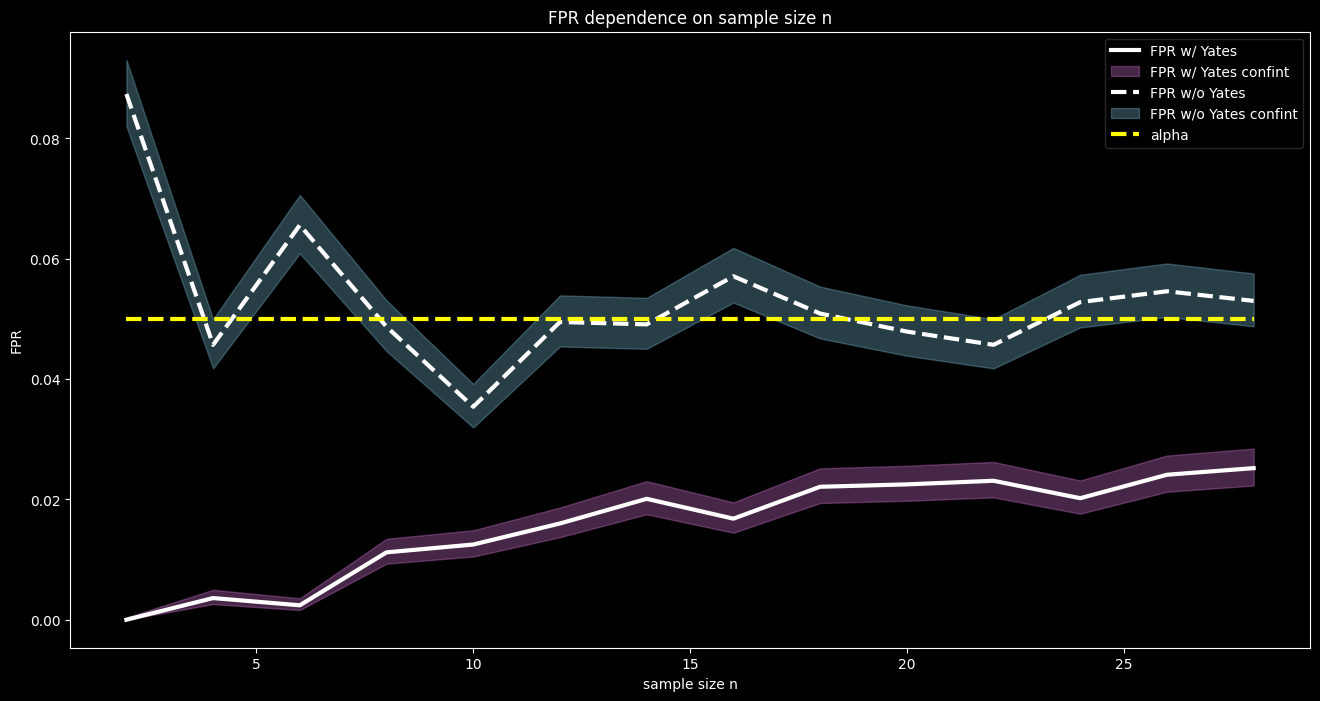

In [ ]:
pyplot.figure(figsize=(16, 8))


pyplot.plot([elem[0] for elem in FPR_list_w_yates],
            [elem[1].positive_rate for elem in FPR_list_w_yates],
            color = 'white', linewidth=3.0, label='FPR w/ Yates')
pyplot.fill_between([elem[0] for elem in FPR_list_w_yates],
                    [elem[1].confint_left_bound for elem in FPR_list_w_yates],
                    [elem[1].confint_right_bound for elem in FPR_list_w_yates],
                    color = 'violet', alpha = 0.3, label='FPR w/ Yates confint')


pyplot.plot([elem[0] for elem in FPR_list_wo_yates],
            [elem[1].positive_rate for elem in FPR_list_wo_yates],
            color = 'white', linestyle = 'dashed',
            linewidth=3.0, label='FPR w/o Yates')
pyplot.fill_between([elem[0] for elem in FPR_list_wo_yates],
                    [elem[1].confint_left_bound for elem in FPR_list_wo_yates],
                    [elem[1].confint_right_bound for elem in FPR_list_wo_yates],
                    color = 'skyblue', alpha = 0.3,
                    label='FPR w/o Yates confint')

pyplot.plot([elem[0] for elem in FPR_list_w_yates],
            numpy.array([0.05]*len(FPR_list_w_yates)),
            color = 'yellow', linestyle = 'dashed', linewidth=3.0, label='alpha')

pyplot.legend(loc='best')
pyplot.title("FPR dependence on sample size n")
pyplot.xlabel("sample size n")
pyplot.ylabel("FPR")

pyplot.show()

**Вывод:** включенная поправка Йейтса уменьшает FPR. Это неудивительно, поскольку p-value в критерии со включенной поправкой Йейтса будет строго выше. В этом случае поправка Йейтса может быть нужна только для $n<10$, чтобы обеспечить корректность критерия.

Давайте теперь проверим влияние на мощность критерия.

In [ ]:
TPR_list_w_yates = []
TPR_list_wo_yates = []

# перебираем размер выборки n
for i in tqdm(numpy.arange(10, 2000, 200, dtype = int)):
    mmk_res_w_yates = gen_monte_carlo_exp_for_chi_sq_homogenity(n = i,
                                                                p1 = 0.3,
                                                                p2 = 0.35,
                                                                correction = True,
                                                                alpha = 0.05,
                                                                N_runs = 10000)
    TPR_list_w_yates.append([i, mmk_res_w_yates])

    mmk_res_wo_yates = gen_monte_carlo_exp_for_chi_sq_homogenity(n = i,
                                                                 p1 = 0.3,
                                                                 p2 = 0.35,
                                                                 correction = False,
                                                                 alpha = 0.05,
                                                                 N_runs = 10000)
    TPR_list_wo_yates.append([i, mmk_res_wo_yates])

100%|██████████| 10/10 [01:05<00:00,  6.54s/it]


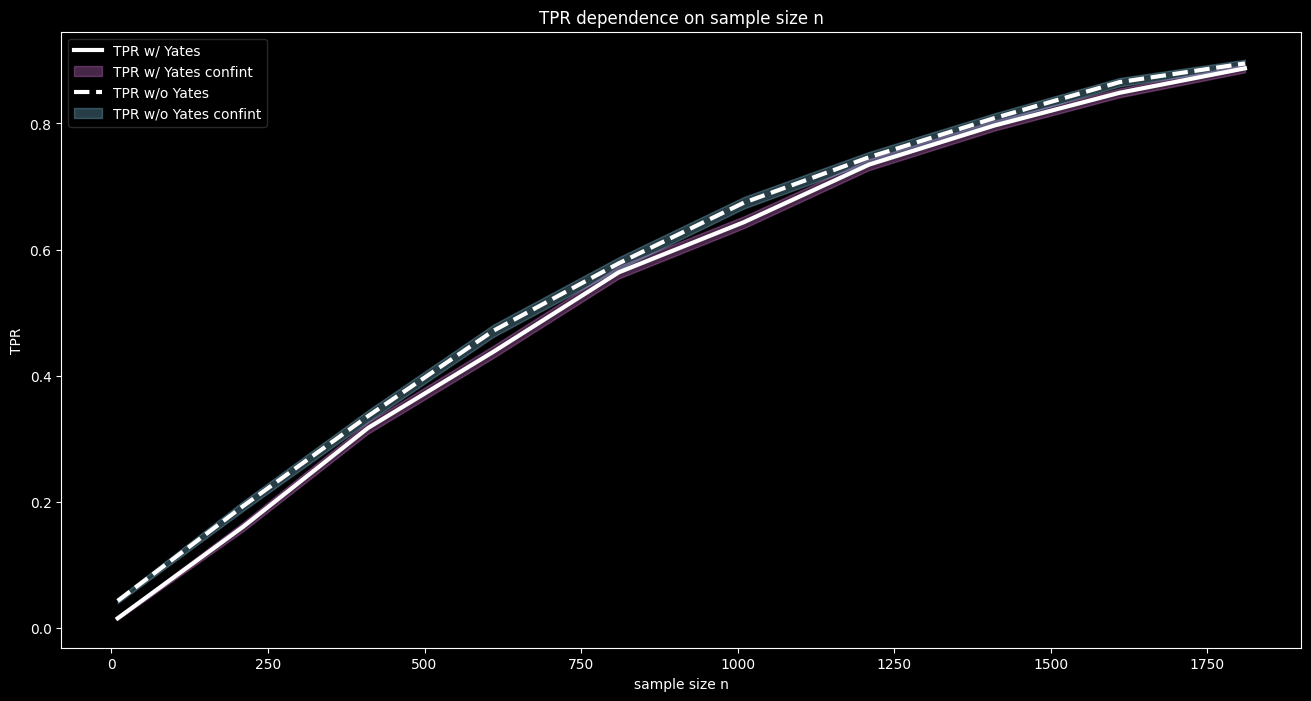

In [ ]:
pyplot.figure(figsize=(16, 8))


pyplot.plot([elem[0] for elem in TPR_list_w_yates],
            [elem[1].positive_rate for elem in TPR_list_w_yates],
            color = 'white', linewidth=3.0, label='TPR w/ Yates')
pyplot.fill_between([elem[0] for elem in TPR_list_w_yates],
                    [elem[1].confint_left_bound for elem in TPR_list_w_yates],
                    [elem[1].confint_right_bound for elem in TPR_list_w_yates],
                    color = 'violet', alpha = 0.3, label='TPR w/ Yates confint')


pyplot.plot([elem[0] for elem in TPR_list_wo_yates],
            [elem[1].positive_rate for elem in TPR_list_wo_yates],
            color = 'white', linestyle = 'dashed', linewidth=3.0, label='TPR w/o Yates')
pyplot.fill_between([elem[0] for elem in TPR_list_wo_yates],
                    [elem[1].confint_left_bound for elem in TPR_list_wo_yates],
                    [elem[1].confint_right_bound for elem in TPR_list_wo_yates],
                    »–color = 'skyblue', alpha = 0.3, label='TPR w/o Yates confint')

pyplot.legend(loc='best')
pyplot.title("TPR dependence on sample size n")
pyplot.xlabel("sample size n")
pyplot.ylabel("TPR")

pyplot.show()

**Вывод:** видим, что мощность критерия с поправкой Йейтса будет ниже, чем без нее. Особенно заметна разница в мощности для небольших $n$. Итого, поправку стоит использовать для небольших $n$ в тех случаях, когда критерий некорректен (чтобы $FPR$ не превышал заданный уровень значимости $\alpha$). Для больших $n$ критерий корректен и без поправки, поправка занижает $FPR$, что приводит к заниженной мощности.

## Выводы

Давайте подведем итог, что же мы сегодня узнали?

1. Вывели критерий согласия Хи-квадрат:
- С простой гипотезой: научились проверять, принадлежит ли выборка дискретному распределению.
- Со сложной гипотезой: научились проверять, принадлежит ли выборка семье дискретных распределений. При этом мы должны оценить параметры распределения при помощи ОМП и не забыть учесть эти оценки при подсчете степеней свободы.

2. Сравнили критерий согласия Колмогорова для непрерывного распределения с критерием согласия Хи-квадрат для дискретизации этого распределения:
- Мощность критерия будет зависеть от характера эффекта: для конкретной задачи с помощью метода Монте-Карло можно попробовать определить, какой критерий будет оптимальным.

3. Вывели критерии однородности и независимости Хи-квадрат:
- Научились проверять, принадлежат ли две выборки одному дискретному распределению (критерий однородности);
- Научились проверять независимость двух случайных величин (критерий независимости).


4. Научились применять поправку Йейтса, которая ускоряет сходимость для малых размеров выборки.